In [1]:
# Merging process of the 6 clean BIOGRID data files, with duplicate revision in the merger
# Proceso de fusion de los 6 archivos limpios de la data BIOGRID

# con revision de duplicados en la fusion


import pandas as pd
import matplotlib.pyplot as plt

# Block paths and final file
# Rutas de los bloques y archivo final
blocks = [
    r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_1_refined.csv',
    r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_2_refined.csv',
    r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_3_refined.csv',
    r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_4_refined.csv',
    r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_5_refined.csv',
    r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_6_refined.csv'
]
final_output = r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks.csv'
duplicate_report = r'C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/cleaned_blocks_duplicate_report.txt'

# Initialize structures
# Inicializar estructuras
all_ids = set()
duplicates = []

print("Revisando duplicados entre bloques...")

# Step 1: Check duplicates between blocks
# Paso 1: Revisar duplicados entre bloques
for block_path in blocks:
    print(f"Cargando... {block_path}...")
    for chunk in pd.read_csv(block_path, chunksize=100000):
        ids_in_chunk = set(chunk['IDENTIFIER_ID'])
        # Encontrar duplicados entre bloques / Find duplicates between blocks
        duplicate_ids = ids_in_chunk & all_ids
        duplicates.extend(duplicate_ids)
        # Agregar IDs al conjunto global/  Add IDs to the global set
        all_ids.update(ids_in_chunk)

# Generate duplicate report
# Generar reporte de duplicados
with open(duplicate_report, 'w') as file:
    if duplicates:
        file.write(f"Se encontraron {len(set(duplicates))} valores duplicados entre bloques.\n")
        file.write("\n".join(map(str, set(duplicates))))
    else:
        file.write("No se encontraron valores duplicados entre bloques.\n")
print(f"Reporte de duplicados generado en {duplicate_report}")

# Step 2: Merge blocks
# Paso 2: Fusionar bloques
print("Fusionando bloques...")
merged_data = pd.concat(
    [pd.read_csv(block_path) for block_path in blocks], 
    ignore_index=True
)

# Step 3: Save merged file
# Paso 3: Guardar archivo fusionado
print("Guardando archivo fusionado...")
merged_data.to_csv(final_output, index=False)
print(f"Archivo fusionado guardado en {final_output}")

# Step 4: Verify merged file
# Paso 4: Verificar archivo fusionado
print("Verificando archivo fusionado...")
total_rows = merged_data.shape[0]
unique_ids = merged_data['IDENTIFIER_ID'].nunique()
duplicates_final = merged_data.duplicated().sum()

print(f"Total de filas: {total_rows}")
print(f"IDs únicos: {unique_ids}")
print(f"Duplicados en el archivo final: {duplicates_final}")

Revisando duplicados entre bloques...
Cargando... C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_1_refined.csv...
Cargando... C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_2_refined.csv...
Cargando... C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_3_refined.csv...
Cargando... C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_4_refined.csv...
Cargando... C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_5_refined.csv...
Cargando... C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/cleaned_block_6_refined.csv...
Reporte de duplicados generado en C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/cleaned_blocks_duplicate_report.txt
Fusionando bloques...
Guardando archivo fusionado...
Archivo fusionado guardado en C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks.csv
Verificando archivo fusionado...
Total de filas: 22930388
IDs únicos: 82754
Duplicados en el archivo final: 5451


In [2]:
# I have to re-clean the merged file to remove duplicates based on key columns.
# Tengo que someter a una nueva limpieza al archivo fusionado para eliminar duplicados basados en columnas claves

# Path of the merged file
# Ruta del archivo fusionado
merged_file = r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks.csv'
final_cleaned_file = r'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_final.csv'
final_report = r'C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/merged_blocks_final_report.txt'

# Configuration for chunk processing
# Configuración para procesamiento por chunks
chunk_size = 1000000  # Tamaño del chunk / Chunk size
columns_to_consider = ['IDENTIFIER_ID', 'IDENTIFIER_TYPE', 'OFFICIAL_SYMBOL', 'SCORE.1', 'SCORE.2']

print("Procesando el archivo fusionado por chunks...")

# Variables for cumulative results
# Variables para resultados acumulados
processed_chunks = []
unique_ids_set = set()

# Read and process by chunks
# Leer y procesar por chunks
for chunk in pd.read_csv(merged_file, chunksize=chunk_size, low_memory=False):
    # Eliminar duplicados dentro del chunk / Delete duplicates within the chunk
    chunk.drop_duplicates(subset=columns_to_consider, inplace=True)

    # Eliminate global duplicates using a set of unique IDs
    # Eliminar duplicados globales utilizando un set de IDs únicos
    mask = chunk['IDENTIFIER_ID'].apply(lambda x: x not in unique_ids_set)
    unique_ids_set.update(chunk.loc[mask, 'IDENTIFIER_ID'])
    processed_chunks.append(chunk[mask])

# Concatenate all processed chunks
# Concatenar todos los chunks procesados
print("Concatenando chunks procesados...")
final_data = pd.concat(processed_chunks, ignore_index=True)
# Save clean file
# Guardar archivo limpio
print("Guardando archivo final limpio...")
final_data.to_csv(final_cleaned_file, index=False)
print(f"Archivo final limpio guardado en {final_cleaned_file}")

# Generate final report
# Generar reporte final
print("Generando reporte final...")
report = []

# General information
# Información general
report.append("=== Información general ===")
report.append(f"Total de filas: {final_data.shape[0]}")
report.append(f"Total de columnas: {final_data.shape[1]}")

# Unique values in IDENTIFIER_ID
# Valores únicos en IDENTIFIER_ID
unique_ids = final_data['IDENTIFIER_ID'].nunique()
report.append(f"IDs únicos: {unique_ids}")

# Null values
# Valores nulos
null_counts = final_data.isnull().sum()
report.append("\n=== Valores nulos por columna ===")
report.append(null_counts.to_string())

# Descriptive statistics
# Estadísticas descriptivas
report.append("\n=== Estadísticas descriptivas ===")
report.append(final_data.describe(include='all').to_string())

# Generate duplicate report
# Generar reporte de duplicados
with open(duplicate_report, 'w') as file:
    if duplicates:
        file.write(f"Se encontraron {len(duplicates)} valores duplicados entre bloques.\n")
        file.write("\n".join(map(str, duplicates)))
    else:
        file.write("No se encontraron valores duplicados entre bloques.\n")
print(f"Reporte de duplicados generado en {duplicate_report}")

# Save report
# Guardar reporte
with open(final_report, 'w') as file:
    file.write("\n".join(report))

print(f"Reporte final generado en {final_report}")


Procesando el archivo fusionado por chunks...
Concatenando chunks procesados...
Guardando archivo final limpio...
Archivo final limpio guardado en C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_final.csv
Generando reporte final...
Reporte de duplicados generado en C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/cleaned_blocks_duplicate_report.txt
Reporte final generado en C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/merged_blocks_final_report.txt


In [4]:
# Review duplicate cleanup and set a unique identifier for the data
# Repasar limpieza de duplicados y establecer un identificador unico para la data

# File paths
# Rutas de archivos
file_path = 'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_final.csv'
output_file = 'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates.csv'
report_file = 'C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/merged_blocks_no_duplicates_report.txt'

# Specific columns to consider duplicates
# Columnas específicas para considerar duplicados
subset_columns = ['IDENTIFIER_ID', 'OFFICIAL_SYMBOL']

# Function to remove duplicates by chunk
# Función para eliminar duplicados por chunk
def eliminar_duplicados_por_chunk(file_path, output_file, chunk_size, report_file, subset_columns):
    try:
        with open(report_file, 'w') as report:
            report.write("=== Reporte de Eliminación de Duplicados ===\n")

        processed_chunks = []
        total_rows_before = 0
        total_rows_after = 0

        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            total_rows_before += len(chunk)
            
            # Delete duplicates based on specific columns
            # Eliminar duplicados basados en columnas específicas
            chunk_deduplicated = chunk.drop_duplicates(subset=subset_columns)
            total_rows_after += len(chunk_deduplicated)

            processed_chunks.append(chunk_deduplicated)
        
        # Combine all processed chunks
        # Combinar todos los chunks procesados
        final_data = pd.concat(processed_chunks, ignore_index=True)

        # Create a unique identifier
        # Crear un identificador único
        final_data['unique_id'] = range(1, len(final_data) + 1)

        # Save the clean file
        # Guardar el archivo limpio
        final_data.to_csv(output_file, index=False)

        # Generate report
        # Generar reporte
        with open(report_file, 'a') as report:
            report.write(f"\nFilas antes de eliminar duplicados: {total_rows_before}\n")
            report.write(f"Filas después de eliminar duplicados: {total_rows_after}\n")
            report.write(f"Archivo limpio guardado en: {output_file}\n")

            # Descriptive reports
            # Informes descriptivos
            report.write("\n=== Estadísticas descriptivas ===\n")
            report.write(final_data.describe(include='all').to_string())

            # Check null values
            # Verificar valores nulos
            null_summary = final_data.isnull().sum()
            report.write("\n\n=== Valores nulos por columna ===\n")
            report.write(null_summary.to_string())

        print("Eliminación de duplicados completada y reporte generado.")
    except Exception as e:
        print(f"Error durante el proceso: {e}")

# Process file by chunks
# Procesar archivo por chunks
eliminar_duplicados_por_chunk(file_path, output_file, chunk_size=100000, report_file=report_file, subset_columns=subset_columns)

Eliminación de duplicados completada y reporte generado.


Reporte de relevancia biológica generado en: C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/relevancia_biologica_report.txt


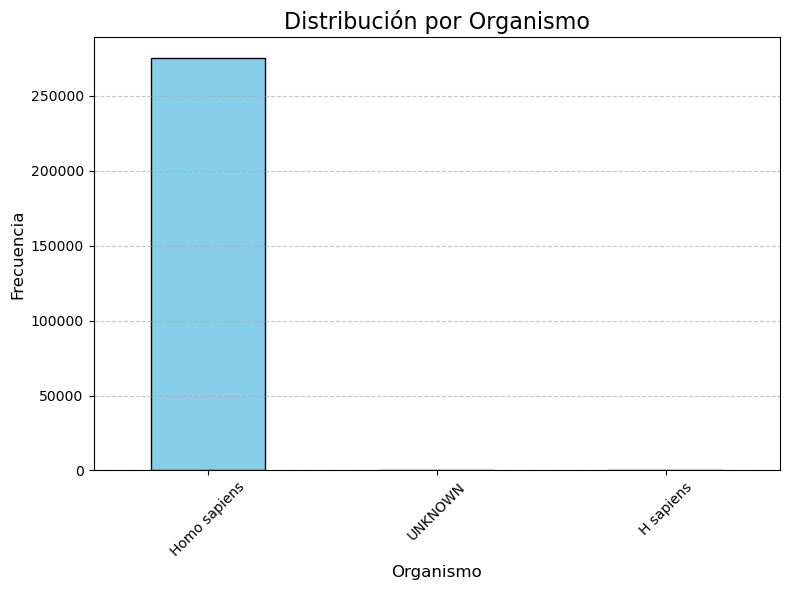

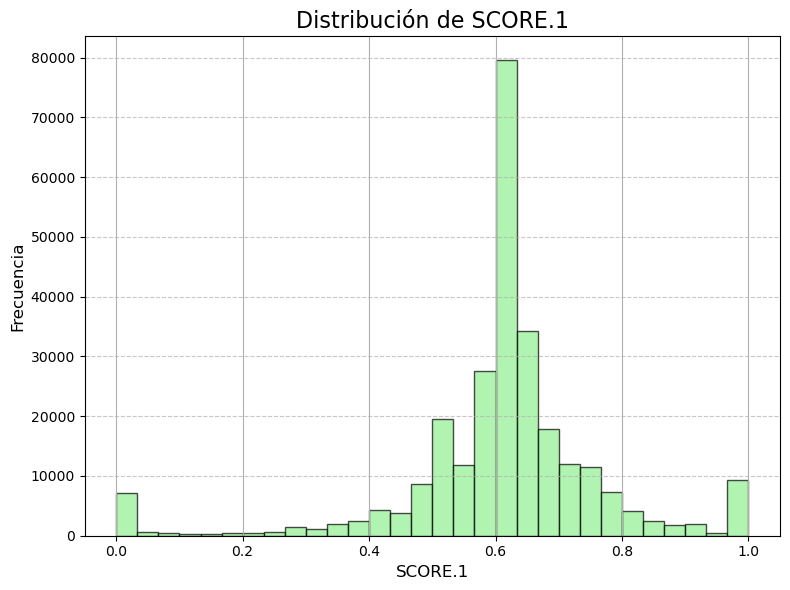

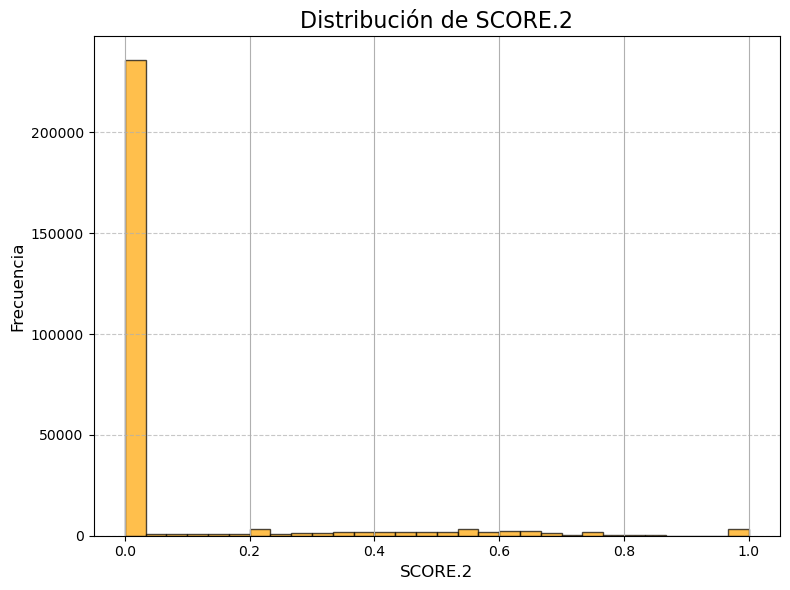

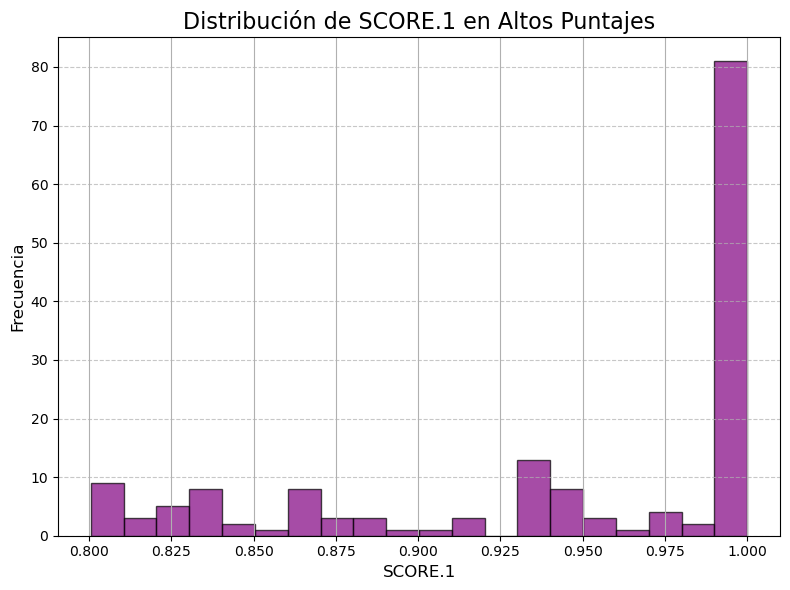

In [5]:
# Review the biological relevance of conserved interactions.
# Revisar la relevancia biológica de las interacciones conservadas 

# File paths
# Rutas de archivos
cleaned_file = 'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates.csv'
report_file = 'C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/relevancia_biologica_report.txt'

# Review the biological relevance of conserved interactions.
# Revisar la relevancia biológica de las interacciones conservadas
def revisar_relevancia_biologica(file_path, report_file):
    try:
        # Cargar el archivo limpio / Load the clean file
        data = pd.read_csv(file_path)

        # Generar reporte de relevancia biológica / Generate biological relevance report
        with open(report_file, 'w') as report:
            report.write("=== Reporte de Relevancia Biológica ===\n")

            # Basic statistics
            # Estadísticas básicas
            report.write("\n=== Estadísticas generales ===\n")
            report.write(data.describe(include='all').to_string())

            
            # Distribution by organism
            # Distribución por organismo
            if 'ORGANISM_OFFICIAL' in data.columns:
                report.write("\n\n=== Distribución por Organismo ===\n")
                organism_distribution = data['ORGANISM_OFFICIAL'].value_counts()
                report.write(organism_distribution.to_string())

                # Distribution visualization by organism
                # Visualización de distribución por organismo
                plt.figure(figsize=(8, 6))
                organism_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
                plt.title('Distribución por Organismo', fontsize=16)
                plt.xlabel('Organismo', fontsize=12)
                plt.ylabel('Frecuencia', fontsize=12)
                plt.xticks(rotation=45, fontsize=10)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.savefig('C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/visualizations/organism_distribution.png')

            # Distribution of SCORE.1 and SCORE.2
            # Distribución de SCORE.1 y SCORE.2
            if 'SCORE.1' in data.columns and 'SCORE.2' in data.columns:
                report.write("\n\n=== Estadísticas de SCORE.1 y SCORE.2 ===\n")
                report.write(data[['SCORE.1', 'SCORE.2']].describe().to_string())

                # SCORE.1 distribution display.
                # Visualización de distribución de SCORE.1
                plt.figure(figsize=(8, 6))
                data['SCORE.1'].hist(bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
                plt.title('Distribución de SCORE.1', fontsize=16)
                plt.xlabel('SCORE.1', fontsize=12)
                plt.ylabel('Frecuencia', fontsize=12)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.savefig('C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/visualizations/score1_distribution.png')

                # SCORE.2 distribution display.
                # Visualización de distribución de SCORE.2
                plt.figure(figsize=(8, 6))
                data['SCORE.2'].hist(bins=30, color='orange', edgecolor='black', alpha=0.7)
                plt.title('Distribución de SCORE.2', fontsize=16)
                plt.xlabel('SCORE.2', fontsize=12)
                plt.ylabel('Frecuencia', fontsize=12)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.savefig('C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/score2_distribution.png')

            # Identify interactions with high scores (SCORE.1 and SCORE.2 > 0.8).
            # Identificar interacciones con altos puntajes (SCORE.1 y SCORE.2 > 0.8)
            high_score_interactions = data[(data['SCORE.1'] > 0.8) & (data['SCORE.2'] > 0.8)]
            report.write("\n\n=== Interacciones con altos puntajes ===\n")
            report.write(f"Total: {len(high_score_interactions)}\n")
            if not high_score_interactions.empty:
                report.write(high_score_interactions.head(10).to_string(index=False))

                # Visualization of high-scoring interactions
                # Visualización de interacciones con altos puntajes
                plt.figure(figsize=(8, 6))
                high_score_interactions['SCORE.1'].hist(bins=20, color='purple', edgecolor='black', alpha=0.7)
                plt.title('Distribución de SCORE.1 en Altos Puntajes', fontsize=16)
                plt.xlabel('SCORE.1', fontsize=12)
                plt.ylabel('Frecuencia', fontsize=12)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.savefig('C:/Polimeromics/data/BIOGRID-CSV/analysis_reports/visualizations/high_score1_distribution.png')

        print(f"Reporte de relevancia biológica generado en: {report_file}")

    except Exception as e:
        print(f"Error al revisar la relevancia biológica: {e}")

# Review biological relevance
# Revisar relevancia biológica
revisar_relevancia_biologica(cleaned_file, report_file)


In [10]:
# Before uploading the data to SQL we must ensure the proper treatment of special characters.
# Antes de subir los datos a SQL debemos garantizar el tratamiento adecuado para los caracteres especiales

import csv

def convert_csv_to_utf8(input_file, output_file):
    """
    Convierte un archivo CSV a codificación UTF-8.

    Args:
        input_file (str): Ruta del archivo CSV original.
        output_file (str): Ruta donde se guardará el archivo convertido.
    """
    try:
        # Open the original file with its current encoding (e.g. latin1)
        # Abrir el archivo original con su codificación actual (por ejemplo, latin1)
        with open(input_file, mode='r', encoding='latin1') as infile:
            # Abrir el archivo de salida con codificación UTF-8 / Open the output file with UTF-8 encoding
            with open(output_file, mode='w', encoding='utf-8', newline='') as outfile:
                reader = csv.reader(infile)
                writer = csv.writer(outfile)
                
                # Read and write each row
                # Leer y escribir cada fila
                for row in reader:
                    writer.writerow(row)
        
        print(f"Archivo convertido correctamente: {output_file}")
    except UnicodeDecodeError:
        print(f"Error: No se pudo leer el archivo {input_file}. Verifica su codificación original.")
    except Exception as e:
        print(f"Error inesperado: {e}")

# Apply the conversion to each file to be integrated in the SQL polimeromic_db database separately
# Aplicar la conversión a cada archivo por integrar en la base polimeromic_db de SQL por separado


convert_csv_to_utf8(
    input_file='C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates.csv',
    output_file='C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates_utf8.csv'
)

convert_csv_to_utf8(
    input_file='C:/Polimeromics/data/polymers_dataset_cleaned.csv',
    output_file='C:/Polimeromics/data/polymers_dataset/polymers_dataset_cleaned_utf8.csv'
)

convert_csv_to_utf8(
    input_file='C:/Polimeromics/data/RCSB_PDB/RCSB_PDB_Macromolecular_Structure_Dataset_cleaned_no_redundancy.csv',
    output_file='C:/Polimeromics/data/RCSB_PDB/RCSB_PDB_Macromolecular_Structure_Dataset_cleaned_no_redundancy_uft8.csv'
)


Archivo convertido correctamente: C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates_utf8.csv
Archivo convertido correctamente: C:/Polimeromics/data/polymers_dataset/polymers_dataset_cleaned_utf8.csv
Archivo convertido correctamente: C:/Polimeromics/data/RCSB_PDB/RCSB_PDB_Macromolecular_Structure_Dataset_cleaned_no_redundancy_uft8.csv


In [1]:
# Use Phyton to suggest the SQL table and automatically generate a table name based on the file name.
# Set the data type of each column (INT, FLOAT, TEXT, TIMESTAMP) based on the contents of the file.

# Utilizare Phyton para que sugiera la tabla SQL y genere automáticamente un nombre de tabla basado en el nombre del archivo
# Ajusta el tipo de dato de cada columna (INT, FLOAT, TEXT, TIMESTAMP) según el contenido del archivo.


import pandas as pd

def analyze_csv_structure(file_path):
    """
    Analiza la estructura de un archivo CSV para sugerir la creación de una tabla SQL con nombres de columnas normalizados y tipos de datos mejor detectados.

    Args:
        file_path (str): Ruta del archivo CSV.

    Returns:
        str: Instrucción SQL sugerida para crear una tabla.
    """
    try:
        # Leer el archivo CSV
        df = pd.read_csv(file_path, encoding='utf-8')

        # Normalizar el nombre de la tabla
        table_name = file_path.split('/')[-1].split('.')[0].replace('-', '_').replace(' ', '_').lower()
        create_table = f"CREATE TABLE {table_name} (\n"

        # Iterar por las columnas para determinar tipos de datos
        for col in df.columns:
            # Normalizar el nombre de la columna
            col_normalized = col.replace('.', '_').replace(' ', '_').lower()

            # Detectar el tipo de dato
            col_type = "TEXT"  # Tipo de datos predeterminado
            if pd.api.types.is_integer_dtype(df[col]):
                col_type = "INT"
            elif pd.api.types.is_float_dtype(df[col]):
                col_type = "FLOAT"
            elif pd.api.types.is_datetime64_any_dtype(df[col]):
                col_type = "TIMESTAMP"

            # Añadir definición de columna
            create_table += f"    {col_normalized} {col_type},\n"

        # Eliminar la última coma y cerrar la declaración
        create_table = create_table.rstrip(',\n') + '\n);'

        return create_table

    except Exception as e:
        return f"Error al analizar el archivo CSV: {e}"

# Ejemplo de uso
file_path = 'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates_utf8.csv'
print(analyze_csv_structure(file_path))


CREATE TABLE merged_blocks_no_duplicates_utf8 (
    identifier_id TEXT,
    identifier_type TEXT,
    official_symbol TEXT,
    aliases TEXT,
    organism_official TEXT,
    score_1 FLOAT,
    score_2 FLOAT,
    hit TEXT,
    unique_id INT
);


In [1]:
# I will convert headers to lowercase
# Convertire los encabezados a minusculas

# File path
# Ruta del archivo
input_file = 'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates_utf8.csv'
output_file = 'C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates_processed_utf8.csv'

# Read and process the file
# Leer y procesar el archivo
df = pd.read_csv(input_file)
df.columns = [col.lower() for col in df.columns]  # Convertir encabezados a minúsculas
df.to_csv(output_file, index=False)

print(f"Archivo procesado guardado en: {output_file}")


Archivo procesado guardado en: C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates_processed_utf8.csv


In [10]:
# I have to normalize the header of two columns before generating the sql table.
# In this case I will do it manually because there are only 9 columns.

# Debo normalizar el encabezado de dos columnas antes de generar la tabla sql
# En este caso la hare de forma manual por ser solo 9 columnas


import pandas as pd

# Leer el archivo CSV
df = pd.read_csv("C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates_processed_utf8.csv")

# Reemplazar puntos en los nombres de las columnas
df.columns = [col.replace('.', '_') for col in df.columns]

# Guardar el archivo con los nombres de columna normalizados
df.to_csv("C:/Polimeromics/data/BIOGRID-CSV/cleaned_blocks/merged_blocks_no_duplicates_processed_normalized_utf8.csv", index=False)

print("Nombres de columnas normalizados:", df.columns)


Nombres de columnas normalizados: Index(['identifier_id', 'identifier_type', 'official_symbol', 'aliases',
       'organism_official', 'score_1', 'score_2', 'hit', 'unique_id'],
      dtype='object')
